In [46]:
!pip install datasets


Import headers

In [47]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from datasets import load_dataset
from collections import Counter
import re
from itertools import chain
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

In [48]:
# Hyperparameters
BATCH_SIZE = 64
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_HEADS = 4
NUM_CLASSES = 4
NUM_LAYERS = 2
DROPOUT = 0.1
EPOCHS = 5
LR = 0.001
MAX_SEQ_LEN = 128
VALIDATION_SPLIT = 0.2

In [49]:
ag_news = load_dataset("ag_news")
train_data = ag_news['train']
test_data = ag_news['test']

In [50]:
def tokenize(text):
    text = re.sub(r'[^\w\s]', '', text.lower())
    return text.split()

In [51]:
def build_vocab(dataset, tokenizer, min_freq=1):
    counter = Counter(chain.from_iterable(tokenizer(text) for text in dataset['text']))
    vocab = {word: idx + 2 for idx, (word, freq) in enumerate(counter.items()) if freq >= min_freq}
    vocab["<unk>"] = 0
    vocab["<pad>"] = 1
    return vocab

vocab = build_vocab(train_data, tokenize)
vocab_size = len(vocab)

In [52]:
def encode(text, vocab, tokenizer, max_len=MAX_SEQ_LEN):
    tokens = tokenizer(text)
    encoded = [vocab.get(token, vocab["<unk>"]) for token in tokens[:max_len]]
    padding = [vocab["<pad>"]] * (max_len - len(encoded))
    return encoded + padding

In [53]:
class AGNewsDataset(Dataset):
    def __init__(self, data, vocab, tokenizer, max_len=MAX_SEQ_LEN):
        self.labels = torch.tensor(data['label'], dtype=torch.long)
        self.texts = torch.tensor([encode(text, vocab, tokenizer, max_len) for text in data['text']], dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.labels[idx], self.texts[idx]

In [54]:
full_train_dataset = AGNewsDataset(train_data, vocab, tokenize)
test_dataset = AGNewsDataset(test_data, vocab, tokenize)

val_size = int(len(full_train_dataset) * VALIDATION_SPLIT)
train_size = len(full_train_dataset) - val_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [55]:
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, hidden_dim, num_heads, num_layers, dropout):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(embed_dim, num_heads, hidden_dim, dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc = nn.Linear(embed_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.embedding(text)
        transformed = self.transformer(embedded.permute(1, 0, 2))
        return self.fc(self.dropout(transformed[0]))


In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TextClassificationModel(vocab_size, EMBEDDING_DIM, NUM_CLASSES, HIDDEN_DIM, NUM_HEADS, NUM_LAYERS, DROPOUT).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [57]:
# Training Loop
def train_epoch(loader):
    model.train()
    total_acc, total_loss = 0, 0
    for labels, text in loader:
        labels, text = labels.to(device), text.to(device)
        optimizer.zero_grad()
        output = model(text)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_acc += (output.argmax(1) == labels).sum().item()
        total_loss += loss.item()
    return total_acc / len(loader.dataset), total_loss / len(loader)


In [58]:
def evaluate(loader):
    model.eval()
    total_acc, total_loss = 0, 0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for labels, text in loader:
            labels, text = labels.to(device), text.to(device)
            output = model(text)
            loss = criterion(output, labels)
            total_acc += (output.argmax(1) == labels).sum().item()
            total_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(output.argmax(1).cpu().numpy())
    return total_acc / len(loader.dataset), total_loss / len(loader), all_labels, all_preds


In [59]:
train_accuracies, train_losses = [], []
val_accuracies, val_losses = [], []

for epoch in range(EPOCHS):
    train_acc, train_loss = train_epoch(train_loader)
    val_acc, val_loss, _, _ = evaluate(val_loader)

    train_accuracies.append(train_acc)
    train_losses.append(train_loss)
    val_accuracies.append(val_acc)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1: Train Acc: 0.7868, Train Loss: 0.5564, Val Acc: 0.8792, Val Loss: 0.3529
Epoch 2: Train Acc: 0.8979, Train Loss: 0.2992, Val Acc: 0.8936, Val Loss: 0.3121
Epoch 3: Train Acc: 0.9238, Train Loss: 0.2282, Val Acc: 0.9008, Val Loss: 0.3018
Epoch 4: Train Acc: 0.9404, Train Loss: 0.1801, Val Acc: 0.9004, Val Loss: 0.3100
Epoch 5: Train Acc: 0.9517, Train Loss: 0.1452, Val Acc: 0.8985, Val Loss: 0.3389


#Test metrics

In [60]:
test_acc, test_loss, true_labels, pred_labels = evaluate(test_loader)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='macro')
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Test Accuracy: 0.8888, Test Loss: 0.3912
Precision: 0.8894, Recall: 0.8888, F1 Score: 0.8887


#Loss and Accuracy Plots

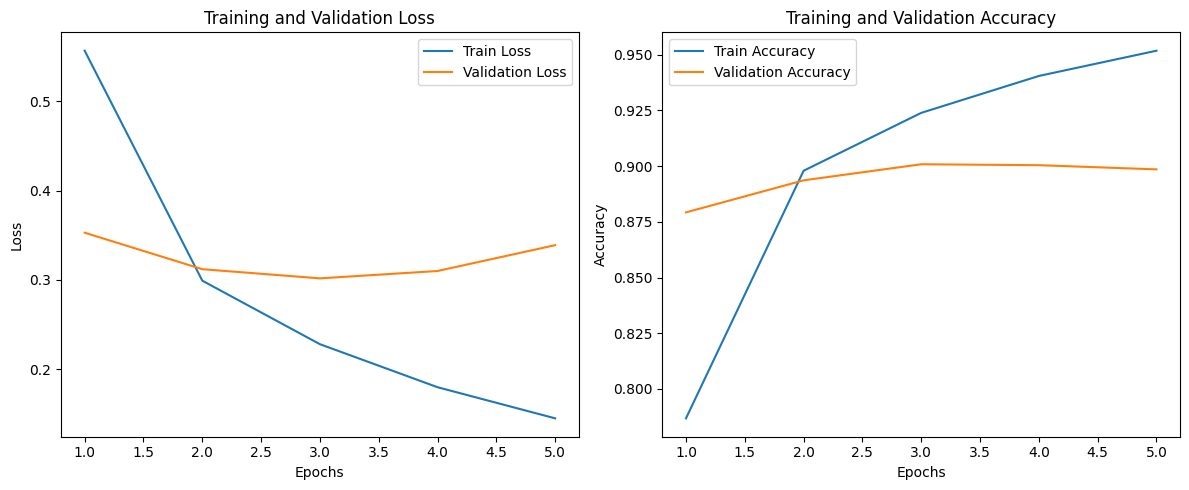

In [61]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_losses, label="Train Loss")
plt.plot(range(1, EPOCHS + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, EPOCHS + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

#Changing hyperparameters

In [62]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_accuracies1, train_losses1 = [], []
val_accuracies1, val_losses1 = [], []

for epoch in range(EPOCHS):
    train_acc1, train_loss1 = train_epoch(train_loader)
    val_acc1, val_loss1, _, _ = evaluate(val_loader)

    train_accuracies1.append(train_acc1)
    train_losses1.append(train_loss1)
    val_accuracies1.append(val_acc1)
    val_losses1.append(val_loss1)

    print(f"Epoch {epoch+1}: Train Acc: {train_acc1:.4f}, Train Loss: {train_loss1:.4f}, Val Acc: {val_acc1:.4f}, Val Loss: {val_loss1:.4f}")

test_acc1, test_loss1, true_labels1, pred_labels1 = evaluate(test_loader)
precision1, recall1, f11, _ = precision_recall_fscore_support(true_labels1, pred_labels1, average='macro')
print(f"Test Accuracy: {test_acc1:.4f}, Test Loss: {test_loss1:.4f}")
print(f"Precision: {precision1:.4f}, Recall: {recall1:.4f}, F1 Score: {f11:.4f}")

Epoch 1: Train Acc: 0.9476, Train Loss: 0.1532, Val Acc: 0.8967, Val Loss: 0.3389
Epoch 2: Train Acc: 0.9574, Train Loss: 0.1261, Val Acc: 0.9006, Val Loss: 0.3630
Epoch 3: Train Acc: 0.9641, Train Loss: 0.1059, Val Acc: 0.8945, Val Loss: 0.3485
Epoch 4: Train Acc: 0.9702, Train Loss: 0.0894, Val Acc: 0.8925, Val Loss: 0.4258
Epoch 5: Train Acc: 0.9747, Train Loss: 0.0746, Val Acc: 0.8899, Val Loss: 0.4315
Test Accuracy: 0.8818, Test Loss: 0.4801
Precision: 0.8850, Recall: 0.8818, F1 Score: 0.8817


In [63]:
LR = 0.01

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_accuracies2, train_losses2 = [], []
val_accuracies2, val_losses2 = [], []

for epoch in range(EPOCHS):
    train_acc2, train_loss2 = train_epoch(train_loader)
    val_acc2, val_loss2, _, _ = evaluate(val_loader)

    train_accuracies2.append(train_acc2)
    train_losses2.append(train_loss2)
    val_accuracies2.append(val_acc2)
    val_losses2.append(val_loss2)

    print(f"Epoch {epoch+1}: Train Acc: {train_acc2:.4f}, Train Loss: {train_loss2:.4f}, Val Acc: {val_acc2:.4f}, Val Loss: {val_loss2:.4f}")

test_acc2, test_loss2, true_labels2, pred_labels2 = evaluate(test_loader)
precision2, recall2, f12, _ = precision_recall_fscore_support(true_labels2, pred_labels2, average='macro')
print(f"Test Accuracy: {test_acc2:.4f}, Test Loss: {test_loss2:.4f}")
print(f"Precision: {precision2:.4f}, Recall: {recall2:.4f}, F1 Score: {f12:.4f}")

Epoch 1: Train Acc: 0.8802, Train Loss: 0.3645, Val Acc: 0.8919, Val Loss: 0.3304
Epoch 2: Train Acc: 0.9123, Train Loss: 0.2706, Val Acc: 0.8931, Val Loss: 0.3310
Epoch 3: Train Acc: 0.9221, Train Loss: 0.2404, Val Acc: 0.8961, Val Loss: 0.3356
Epoch 4: Train Acc: 0.9251, Train Loss: 0.2305, Val Acc: 0.8893, Val Loss: 0.3343
Epoch 5: Train Acc: 0.9326, Train Loss: 0.2060, Val Acc: 0.8877, Val Loss: 0.3594
Test Accuracy: 0.8893, Test Loss: 0.3731
Precision: 0.8916, Recall: 0.8893, F1 Score: 0.8893
